## initial setting

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# 支持多行输出
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' #默认为'last'

In [3]:
import copy
import matplotlib.pyplot as plt

## Package Importing

In [4]:
import numpy as np
import torch
import torch.backends.cudnn as cudnn
import warnings
import datetime
import pickle as pkl
import os
import random
import copy
import scanpy as sc
from sklearn import metrics
import anndata as ad
import pandas as pd
from itertools import chain

In [5]:
from HeCo_ST.emb_clustering import Emb_Clustering
from HeCo_ST.get_emb import get_all_emb
from HeCo_ST.utils import preprocess, construct_graph, cluster_func, batch_effect_removal
import tool.metrics_index as tool_metric
from HeCo_ST.emb_clustering_HAN import Emb_Clustering_HAN

## method definition

### cluster_performance

In [6]:
def cluster_performance(ad, annotation_key, cluster_key, slice_name):

    real_y = ad.obs[annotation_key][~ad.obs[annotation_key].isna()]
    pre_y = ad.obs[cluster_key][~ad.obs[annotation_key].isna()]
    ari_score = metrics.adjusted_rand_score(real_y, pre_y)
    nmi_score = metrics.normalized_mutual_info_score(real_y, pre_y)
    ac_score = metrics.accuracy_score(real_y, pre_y)

    print("{} | ARI:{:.4f}, NMI:{:.4f}, AC:{:.4f}".format(slice_name, ari_score, nmi_score, ac_score))
    return ari_score, nmi_score, ac_score

### evaluate_cluster_performance

In [7]:
def evaluate_cluster_performance(adata, 
                                 annotation_key='ground_truth', 
                                 cluster_key='mclust', 
                                 slice_key='batch'):
    
    print(f"=====Metrics for {cluster_key}=====")
    accuracy_list = {'all': {}}
    ari_score, nmi_score, ac_score = cluster_performance(adata, 
                                                         annotation_key=annotation_key,
                                                         cluster_key=cluster_key, 
                                                         slice_name='all')
    accuracy_list['all']['ARI'] = ari_score
    accuracy_list['all']['NMI'] = nmi_score
    accuracy_list['all']['AC'] = ac_score

    for slice_name in list(adata.obs[slice_key].unique()):
        temp_ad = adata[adata.obs[slice_key] == slice_name]
        ari_score, nmi_score, ac_score = cluster_performance(temp_ad, 
                                                   annotation_key=annotation_key,
                                                   cluster_key=cluster_key, 
                                                   slice_name=slice_name)
        
        accuracy_list[slice_name] = {}
        accuracy_list[slice_name]['ARI'] = ari_score
        accuracy_list[slice_name]['NMI'] = nmi_score
        accuracy_list[slice_name]['AC'] = ac_score

    return accuracy_list

### fix_seed

In [8]:
def fix_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    cudnn.deterministic = True
    cudnn.benchmark = False
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

## parameter setting

In [9]:
dataset_name = 'DLPFC'

In [10]:
batch_key='slice_name'
batch_removal_method='harmony' # harmony, ae
n_comps=32
n_neigh=20
tao=0.9

nb_epochs=1000
hidden_dim_list=[64]
w_intra=1
w_re=1
w_inter=1

cluster_num=7
cluster_method='mclust'
device=None
seed=2023

In [11]:
fix_seed(seed)

## data reading

In [12]:
st_DLPFC_673 = sc.read_h5ad('../data/h5ad/ST_10X_DLPFC_151673.h5ad')
st_DLPFC_674 = sc.read_h5ad('../data/h5ad/ST_10X_DLPFC_151674.h5ad')
st_DLPFC_675 = sc.read_h5ad('../data/h5ad/ST_10X_DLPFC_151675.h5ad')
st_DLPFC_676 = sc.read_h5ad('../data/h5ad/ST_10X_DLPFC_151676.h5ad')

In [13]:
st_list = copy.deepcopy([
    st_DLPFC_673, 
#     st_DLPFC_674, 
    st_DLPFC_675, 
#     st_DLPFC_676,
])
st_name_list = [
    '151673', 
#     '151674', 
    '151675', 
#     '151676',
]

In [14]:
nei_num=len(st_name_list)-1

## slice Integration

### preprocess

In [15]:
adata = preprocess(st_list, st_name_list)

### batch effect removal

In [16]:
batch_effect_removal(adata, 
                     method_type=batch_removal_method,
                     batch_key=batch_key,
                     n_comps=n_comps,
                     device=device)

=====Use harmony to remove batch effect=====


2025-03-07 06:13:12,366 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-03-07 06:13:13,114 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-03-07 06:13:13,144 - harmonypy - INFO - Iteration 1 of 10
2025-03-07 06:13:14,102 - harmonypy - INFO - Iteration 2 of 10
2025-03-07 06:13:15,072 - harmonypy - INFO - Iteration 3 of 10
2025-03-07 06:13:16,075 - harmonypy - INFO - Iteration 4 of 10
2025-03-07 06:13:17,018 - harmonypy - INFO - Converged after 4 iterations


### heterogeneous graph construction

In [17]:
print('construct graph...')
graph_dict = construct_graph(adata, st_name_list,
                             n_neigh=n_neigh,
                             tao=tao,
                             cluster_num=cluster_num,
                             device=device)

construct graph...
construct graph use device: cuda:0
get data_list time: 1.171999
construct graph_dict time: 4.336633


### feature extraction

In [18]:
print(f'========GRASS========')
emb_clustering = Emb_Clustering(st_name_list, graph_dict,
                                nb_epochs=nb_epochs,
                                device=device)

print('start train...')
emb_clustering.run_algorithm(hidden_dim_list=hidden_dim_list,
                             sample_rate=[6]*nei_num,
                             nei_num=nei_num, 
                             w_intra=w_intra, w_re=w_re, w_inter=w_inter)
print("get embedding...")
emb_clustering.get_embedding(adata, st_list)

========GRASS========
use device: cuda:0
start train...
loss  tensor(13.3019)
loss  tensor(12.2871)
loss  tensor(11.6911)
loss  tensor(11.2817)
loss  tensor(11.0083)
loss  tensor(10.7583)
loss  tensor(10.5496)
loss  tensor(10.4024)
loss  tensor(10.3151)
loss  tensor(10.2577)
loss  tensor(10.2160)
loss  tensor(10.1889)
loss  tensor(10.1606)
loss  tensor(10.1441)
Early stopping!
get embedding...


### clustering

In [20]:
emb_clustering.identify_spatial_domain(adata, cluster_num=cluster_num,
                                       cluster_method=cluster_method)

=====Use mclust to identify spatial domain=====
cluster shape: (7231, 64)


R[write to console]:     __  ___________    __  _____________
   /  |/  / ____/ /   / / / / ___/_  __/
  / /|_/ / /   / /   / / / /\__ \ / /   
 / /  / / /___/ /___/ /_/ /___/ // /    
/_/  /_/\____/_____/\____//____//_/    version 5.4.9
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


In [22]:
metrics_dict = evaluate_cluster_performance(adata,
                                            annotation_key='ground_truth',
                                            cluster_key=cluster_method,
                                            slice_key=batch_key)

=====Metrics for mclust=====
all | ARI:0.5692, NMI:0.6808, AC:0.0000
151673 | ARI:0.6183, NMI:0.7073, AC:0.0000
151675 | ARI:0.5297, NMI:0.6804, AC:0.0000


## slice alignment

In [24]:
import HeCo_ST.grass_alignment

In [26]:
GRASS_Alignment = HeCo_ST.grass_alignment.GRASS_Alignment

In [27]:
align_model = GRASS_Alignment(adata, st_name_list, st_list,
                              cluster_method=cluster_method)

In [28]:
align_model.get_anchors()
align_model.construct_multi_graph()

INFO:root:source: 151673, target: 151675 | anchor number: 23096


In [29]:
Adj_list = [graph_dict[s_n]['mps'][0] for s_n in st_name_list]

In [30]:
align_model.align_multi_slice(Adj_list)

==========alignment spot=============
source slice:151673, target slice:151675
Add seed links : 4014	
 ------ The current iteration : 0 ------

 start adding a seed nodes
Tversky sim calculation..
Tversky time : 45sec

 ------ The current iteration : 1 ------

 start adding a seed nodes
Tversky sim calculation..
Tversky time : 38sec

 ------ The current iteration : 2 ------

 start adding a seed nodes
Tversky sim calculation..
Tversky time : 32sec

 ------ The current iteration : 3 ------

 start adding a seed nodes
Tversky sim calculation..
Tversky time : 27sec

 ------ The current iteration : 4 ------

 start adding a seed nodes
Tversky sim calculation..
Tversky time : 23sec
total time : 194sec


In [31]:
source_anchor_dict, source_matching_dict = align_model.source_anchor_dict, align_model.source_matching_dict

## tissue reconstruction

In [32]:
cluster_align_list = [3, 3]

In [33]:
key_points, aligned_points_dict, aligned_points_all_dict = align_model.reconstruct_3D_tissue(cluster_align_list)

==========3D reconstruction==========
source slice:151673, target slice:151675


## results evaluation

In [34]:
def evaluate_align_performance(adata_list, slice_name_list, matching_list, evaluate_type='same_cluster'):
    accuracy_list = []
    if evaluate_type == 'same_cluster':
        print("evaluate alignment | ")
        for index in range(len(matching_list)):
            corr_num = 0
            source_adata = adata_list[index]
            target_adata = adata_list[index + 1]
            source_name = slice_name_list[index]
            target_name = slice_name_list[index + 1]
            matching = matching_list[source_name]
            for k, v in matching.items():
                if source_adata.obs['ground_truth'][k] == target_adata.obs['ground_truth'][v]:
                    corr_num += 1
            accuracy = corr_num / len(matching)
            print("alignment {}-{}:{:.4f}".format(source_name, target_name, accuracy))
            accuracy_list.append(accuracy)
        print("average accuracy:{:.4f}".format(np.mean(accuracy_list)))

    return accuracy_list

In [35]:
ac = evaluate_align_performance(st_list, st_name_list, source_matching_dict)

evaluate alignment | 
alignment 151673-151675:0.7906
average accuracy:0.7906


## visualization

### alignment

In [36]:
from STVisual.multi_slice import match_3D_multi

In [37]:
source_index = 0
adata_source = st_list[source_index].copy()
adata_target = st_list[source_index+1].copy()
anchor = source_matching_dict[st_name_list[source_index]]

In [38]:
matching = np.array([list(anchor.values()), list(anchor.keys())])

adata_source_df = pd.DataFrame({'index': range(adata_source.shape[0]),
                        'x': adata_source.obsm['spatial'][:,0],
                        'y': adata_source.obsm['spatial'][:,1],
                        'domain': adata_source.obs['ground_truth']})
adata_target_df = pd.DataFrame({'index': range(adata_target.shape[0]),
                        'x': adata_target.obsm['spatial'][:,0],
                        'y': adata_target.obsm['spatial'][:,1],
                        'domain': adata_target.obs['ground_truth']})

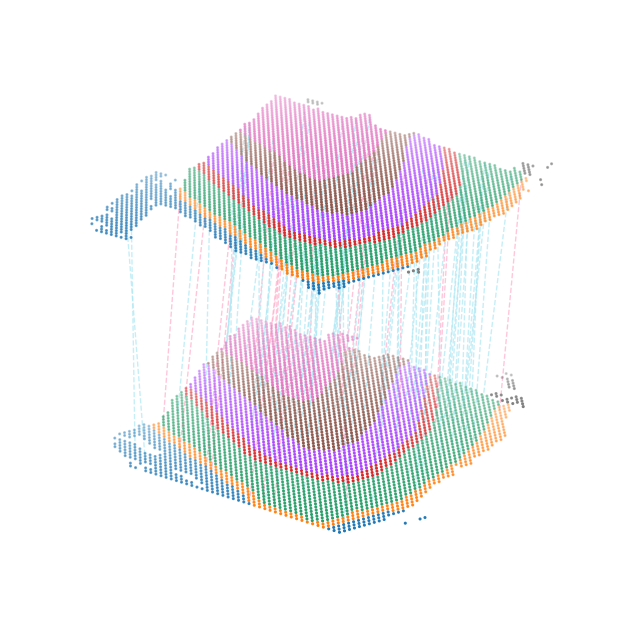

In [39]:
multi_align = match_3D_multi(adata_source_df, adata_target_df, matching, 
                             meta='domain', scale_coordinate=True, 
                             subsample_size=100)
multi_align.draw_3D(size=[9, 8], line_width=1, 
                    point_size=[1.5, 1.5], hide_axis=True)

### 3D reconstruction

In [40]:
from STVisual.multi_slice import plot_aligned_slice, plot_slices_loc, plot_stacked_slices_3d

In [41]:
source_slice_name = st_name_list[0]
target_slice_name = st_name_list[1]
source_data = st_list[0]
target_data = st_list[1]
source_cluster_index = cluster_align_list[0]
target_cluster_index = cluster_align_list[1]
target_aligned_section = aligned_points_dict[target_slice_name]
target_aligned_all = aligned_points_all_dict[target_slice_name]

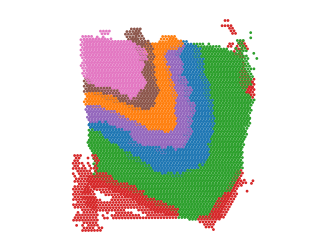

In [42]:
plot_slices_loc(st_list,spatial_key='spatial',
                cluster_key='mclust', legend=False)

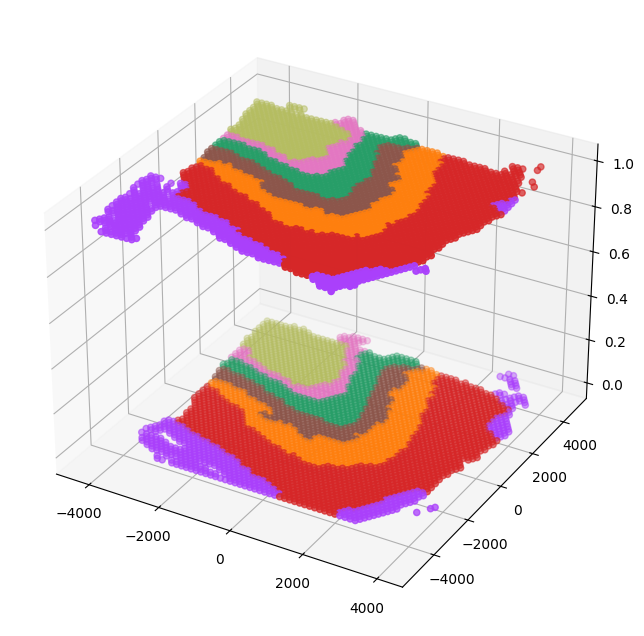

In [43]:
plot_stacked_slices_3d(st_list, st_name_list, aligned_points_all_dict, cluster_method=cluster_method)